# 2. DeepTICA: design CVs as slow modes of biased simulations

Reference paper: _Bonati, Piccini and Parrinello, [PNAS](https://www.pnas.org/doi/10.1073/pnas.2113533118) (2020)_ [[arXiv]](https://arxiv.org/abs/2107.03943). 

The aim of this second tutorial is to illustrate how we can design collective variables by analyzing a biased simulation, identifying the modes which hamper its convergence towards the Boltzmann distribution and subsequently biasing them to improve sampling.

### Introduction

**Collective variables as slow modes**

In the framework of the Variational Approach to Conformation Dynamics (VAC), we can relate the eigenfunctions of the transfer operator (which evolves the probability density towards Boltzmann distribution) to the modes that relax more slowly towards the equilibrium. In a rare event scenario, these eigenfunctions are thus connected to the rare transitions between long-lived metastable states. To search for them, we can resort to a variational principle which tells us that these functions are characterized by the highest autocorrelation. Thus, they can be found with a statistical method called Time-lagged independent component analysis (TICA). 

TICA searches for the linear combinations of input features that are maximally autocorrelated and orthogonal to each other. This amounts to solving the following generalized eigenvalue problem:

$$ C(\tau) w_i = \lambda_i C(0) w_i$$

where $w_i$ are the eigenvectors associated to eigenvalues $\lambda_i$ and $C_{ij}(\tau)=<d_i(t)d_j(t+\tau)>$ is the time-correlation computed at lag-time $\tau$ between the descriptors.

**Deep TICA**

As in the previous tutorial, we can use a neural network to learn a feature map of the input into a latent space which allows maximizing the eigenvalues (i.e. the autocorrelation). As can be seen from the figure, the workflow is very similar to the previous DeepLDA method. What changes are the input data (here we need reactive trajectories) and the criterion used to train the NN (to maximize autocorrelation of the output variables rather than to separate the states). Indeed, the loss function here will be to maximize the squared sum of the eigenvalues of the TICA problem, applied to the outputs of the NN.

![DeepTICA scheme](images/DeepTICA_scheme.png)

**Biased simulations**

These methods have been widely exploited to analyze long trajectories of biomolecular systems, made available for example by ad-hoc built computers. However, the main problem in the use of these methods is the need for data on the long-time dynamics of the system, which are rarely available. To overcome this obstacle, we follow a two-step approach. A first exploratory enhanced sampling simulation is performed. This step does not necessarily require the use of a CV-based method and does not even need to be fully converged. It only needs to report on the transition pathways. Then, these enhanced sampling simulations are analyzed and their slow modes are extracted. 

To apply these methods not only to unbiased simulations but also to enhanced sampling we need to reweight the trajectory to account for the presence of the bias potential. This leads to considering an instantaneous acceleration of the timescales due to the bias potential. Note however that this requires some care from a numerical perspective, as we need to compute the correlation functions of an *exponentially* unevenly spaced time series.

An important point to note is the following: even when performing such reweighting, what we will learn are the slow modes of the biased dynamics towards the Boltzmann distribution. These might differ from the one of an unbiased simulation. For instance, if a variable has been accelerated by the addition of bias potential, the signal of such variable in the slow modes might be weaker. For these reasons, we recommend biasing these slow modes in addition to the previous bias potential. This can be also achieved by using a static bias obtained at the end of the first simulation, without the need of optimizing a multi-dimensional bias.

**Outline**

The three main steps of this method are the following:
1. Perform an enhanced sampling calculation using some approximate CVs as well as generalized ensembles simulations (e.g. multicanonical).
2. Use this trajectory to train a neural-network to approximate the maximally autocorrelated modes, which correspond to the slowest degrees of freedom.
3. Bias these slow degrees of freedom to improve sampling

As before, we focus once again on the **alanine dipeptide** molecule. We will start by biasing it using a very bad CV (the $\psi$ angle), which is often used as a prototypical example of a CV not to be used. Then we will approach it differently, by performing a multithermal simulation in which we want to sample all the conformation relevant to different temperatures, through a bias applied to the potential energy. In both cases we will show how, starting from suboptimal simulations, we can extract the slow modes and consequently accelerate them to greatly improve sampling.

## Setup

In [1]:
import mlcvs
from mlcvs.utils.io import load_dataframe
import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import pandas as pd

def clean(folder='./'):
    subprocess.run("rm bck.* COLVAR* KERNELS* STATE* DELTAFS alanine*", cwd=folder, shell=True)
    
def execute(command, folder):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

#GMX_CMD = '. /work/sourceme.sh && gmx_mpi'
GMX_CMD = 'gmx_mpi'

In [2]:
# Define a few plotting functions

def plot_ramachandran(x,y,z,scatter=None, ax=None):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title(f'Ramachandran plot')

    # Plot countour plot
    h = ax.hexbin(x,y,C=z,cmap='fessa')
    cbar = plt.colorbar(h,ax=ax)
    cbar.set_label(f'Deep-TICA')

    axs[0].set_xlabel(r'$\phi$ [rad]')
    axs[0].set_ylabel(r'$\psi$ [rad]')

def plot_cv_histogram(s,label=None,ax=None,**kwargs):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title('Histogram')

    if (type(s)==torch.Tensor):
        s = s.squeeze(1).detach().numpy()

    # Plot histogram
    ax.hist(s,**kwargs)
    if label is not None:
        ax.set_xlabel(label)

## 2.1 Deep-TICA CVs from a (very) poor CV

### 1. Initial simulation: $\psi$

![Ala2](images/alanine.png)

Let's imagine that, by looking at the alanine dipeptide molecule, we guessed the torsion angle $\psi$ to be associated with a slow mode of the system. We have thus decided to perform a simulation biasing it.

Below you can find the input file to perform such a simulation using OPES. However, since we need to simulate it for a long time (several microseconds) to observe some transitions and this requires time, you will find the outputs of such simulation already in the folder.

As in the previous tutorial, to stress test the method we will use a sub-optimal set of descriptors, namely the interatomic distances between heavy atoms, and let the neural network do the job to find a non-linear combination of them that is appropriate to describe the slow modes.

In [3]:
folder = '2_DeepTICA/1_psi/1_opes-psi/'

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute descriptors
INCLUDE FILE=../../plumed-distances.dat

# Define bias
opes: OPES_METAD ARG=psi BARRIER=40 SIGMA=0.15 PACE=500 STATE_WFILE=STATE_PSI

# Print 
PRINT FMT=%g STRIDE=2500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

If we look at the time evolution of $\psi$ we see that this is indeed a poor choice of the CV. We need to wait for microseconds before observing a handful of transitions. Nevertheless, we want to use this data to extract a better CV.


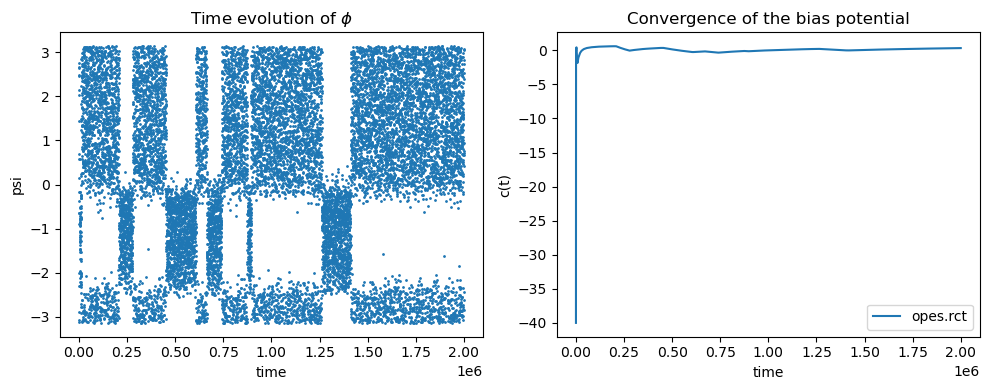

In [4]:
folder = '2_DeepTICA/1_psi/1_opes-psi/'
colvar = load_dataframe(folder+'COLVAR',stop=400000,stride=5)

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=100)
# Time evolution (phi)
colvar.plot.scatter('time','psi',s=1,ax=axs[0],cmap='fessa')
axs[0].set_title('Time evolution of $\phi$')
# c(t) evution
colvar.plot('time','opes.rct',ax=axs[1])
axs[1].set_title('Convergence of the bias potential')
axs[1].set_ylabel('c(t)')
plt.tight_layout()

From the time evolution of the c(t) quantity in the COLVAR file we see that also in this case the opes bias converges quickly, and this implies that the transitions that we observe are in a quasi-static regime, from which a standard umbrella-like reweighting can be applied. We will discard the first part of the simulation and analyze the rest.

### Train DeepTICA CVs

In [5]:
# Load files
folder = '2_DeepTICA/1_psi/1_opes-psi/'
colvar = load_dataframe(folder+'COLVAR',start=10000,stop=40000,stride=1) # we discard the first 500 ns

# Select descriptors
X = colvar.filter(regex='d_').values
t = colvar['time'].values
n_input = X.shape[1]

print(X.shape)  

(30000, 45)


**Compute weights for time rescaling**

In order to compute the autocorrelation functions from a biased simulation we first need to  rescale the time to account for the effect of the bias potential. Since we are in a quasi-static regime, we can simply use the following umbrella-sampling-like formula for the weights:

$$ w = e^{\beta\ V} $$

From the weights we  then compute the instantaneus acceleration at step $k$ as:

$$ dt'_k = w_k\ dt $$

and hence the cumulative rescaled time as:

$$ t'_k = \sum_{i=0} ^k dt'_i $$

In [6]:
temp = 300.        #reweighting temperature

kb=0.008314
kbt=kb*temp

# compute logweights
bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load all *.bias columns and sum them
logweight = bias/kbt

**Create dataset of time-lagged configurations**

In order to train the Deep-TICA CVs we will need to compute the time-lagged covariance matrices in the rescaled time $t'$. The standard way is to look for configurations which are distant a lag-time $\tau$ in the time series. However, in the rescaled time the time-series is _exponentially_ unevenly spaced. Hence, a naive search will lead to severe numerical issue. To address this, we resort to the algorithm described in (Yang and Parrinello, _Journal of chemical theory and computation_ (2018)). 

To generate the the training and validation set, we use the function `create_time_lagged_dataset` which searches for the pairs of configurations and the corresponding weight. This is divided in training and validation data, and fed to a `FastTensorDataloader` which allows for an efficient training.

A note on the choice of the lag-time: if we were to apply this method to an unbiased simulation, the meaning of $\tau$ would be to look at correlations on timescales greater than it. Hovewer, when rescaling the time to account for the bias potential we lose this perspective. So in order to choose it we can train a model with different lag-times and choose look for the following two requirements:
- all the eigenvalues you want to optimize are not decayed to zero (avoid values too large)
- the eigenvalues are not degenerate (avoid too small values)

In [24]:
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from torch.utils.data import Subset,random_split

lag_time = 10

# create dataset
dataset = create_time_lagged_dataset(X,t=t,
                                       lag_time=lag_time,
                                       logweights=logweight)

n_train  = int( 0.8 * len(dataset) )
n_valid  = len(dataset) - n_train

# split train - valid 
train_data = Subset(dataset, np.arange(n_train))
valid_data = Subset(dataset, np.arange(n_train,n_train+n_valid))

# create dataloaders 
train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

Time-lagged pairs:	 59968
Training data:		 47974
Validation data:	 11994


**Training the DeepTICA CVs**

 Several parameters are similar to the the ones used in the training of DeepLDA, with the exception of `loss_type` and `n_eig`. They are relative at the objective function that is being maximized. 

Here `loss_type` specifies the object that is maximized in the loss, and it can be:
- "sum2": sum of square of the eigenvalues
- "sum": sum of the eigenvalues
- "single": only a single eigenvalue (which eigenvalue is specified by `n_eig`)

In the following we train a model to reconstruct the slowest DeepTICA 1 CV (using `loss_type=sum2` and `n_eig=1`).

---

| Parameter | Type | Description |
| :- | :- | :- |
| **Neural network** |
| nodes | list | NN architecture (last value equal to the number of hidden layers which are input of TICA)  |
| activ_type | string | Activation function (relu,tanh,elu,linear) |
| **loss_type** | string | Loss function operating on the TICA eigenvalues (sum2,sum,single)|
| **n_eig** | int | Number of eigenvalues to optimize (or if loss_type=single which one to select) |
| **Optimization** |
| lrate | float | Learning rate |
| num_epochs | int | Number of epochs |
| **Early Stopping** |
| earlystop | bool | Whether to use early stopping based on validation loss |
| es_patience | int | Number of epochs before stopping |
| es_consecutive | bool | Whether es_patience should count consecutive (True) or cumulative patience |
| **Log** |
| log_every | int | How often print the train/valid loss during training |

See class documentation for further details about parameters and methods.

In [25]:
from mlcvs.tica import DeepTICA_CV

#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = 1

lrate             = 1e-3

num_epochs        = 1000
earlystop         = True
es_patience       = 10

log_every         = 10
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(nodes)
model.to(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate)
model.set_optimizer(opt)
model.set_earlystopping(patience=es_patience,min_delta=0.001, log=False)

# TRAIN
model.fit(train_loader,valid_loader,
            standardize_inputs=True,
            standardize_outputs=True,
            loss_type=loss_type,
            n_eig=n_eig,
            nepochs=num_epochs,
            info=False, log_every=log_every)

Epoch Train Loss  Valid Loss  Eigenvalues             
10    -0.915      -0.913      0.953  0.470  
20    -0.952      -0.952      0.974  0.483  
30    -0.970      -0.967      0.984  0.483  
40    -0.978      -0.977      0.989  0.491  
50    -0.984      -0.981      0.992  0.487  
60    -0.988      -0.985      0.994  0.489  
70    -0.990      -0.987      0.995  0.487  
80    -0.992      -0.990      0.996  0.488  
90    -0.993      -0.991      0.997  0.487  
100   -0.994      -0.992      0.997  0.486  
110   -0.995      -0.994      0.997  0.486  
INFO: Early stopping
111   -0.995      -0.994      0.997  0.486  


We can plot the learning curve and also see the evolution of the eigenvalues along the training (interesting especially if there is more than one).

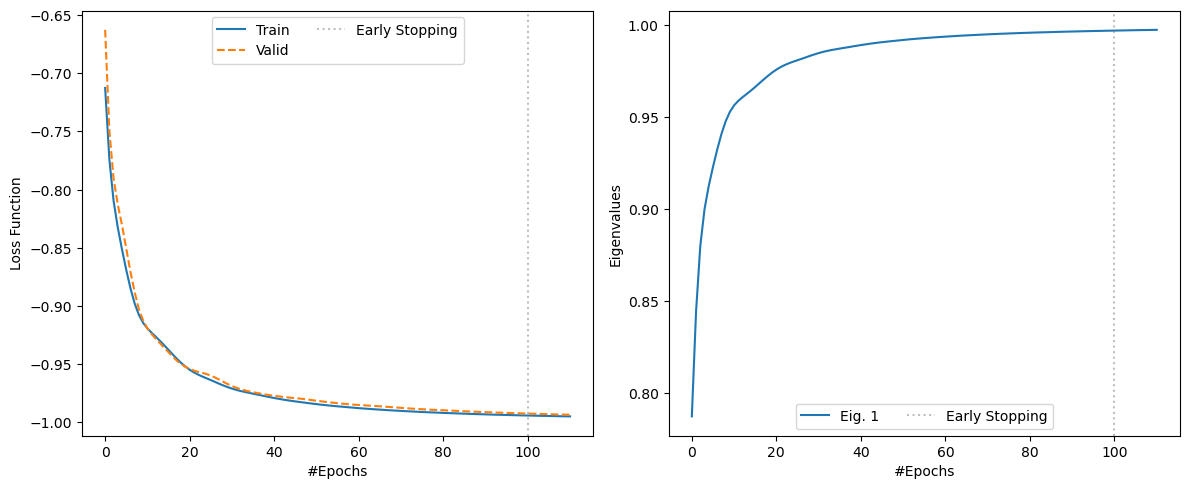

In [26]:
fig, axs = plt.subplots(1,2,figsize=(12,5),dpi=100)

loss_train = [x.cpu() for x in model.loss_train]
loss_valid = [x.cpu() for x in model.loss_valid]

# Loss function
ax = axs[0]
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

# Eigenvalues vs epoch
ax = axs[1]
with torch.no_grad():
    evals_train = np.asarray(torch.cat(model.evals_train).cpu())
for i in range(n_eig):
    ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
ax.set_ylabel('Eigenvalues')

# Common setup
for ax in axs:
    if model.earlystopping_.early_stop:
        ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
        ax.set_xlabel('#Epochs')
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()

How can we understand what is the physical meaning of the different CVs? One possibility is to check how the DeepTICA CVs changes in a physical space, e.g. the ramachandran plot ($\phi,\psi$).

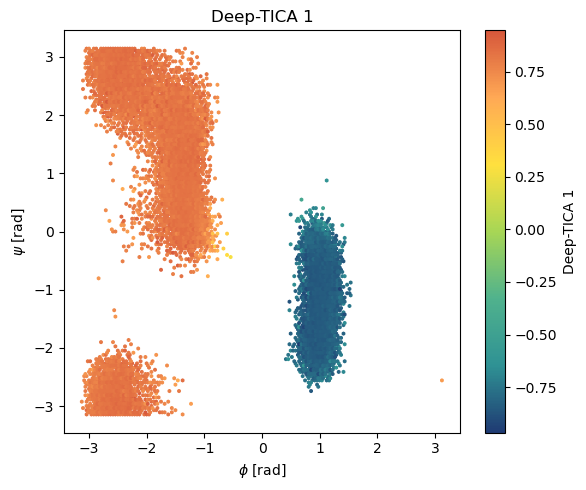

In [27]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

if n_eig ==1:
    axs = [axs]
    
x = colvar['phi'].values
y = colvar['psi'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

**Exercise** : train multiple CVs

Repeat the training by changing `loss_type` and/or `n_eig` to optimize also the second eigenvalue. 

- Are the results related to the first DeepTICA 1 CV robust? And what about the second one? Is the value of the lag-time used suitable to recover also the second DeepTICA 2 CV?

- How can we understand if the two CVs are related to slow or fast modes? Try to plot also time evolution of the two DeepTICA CVs along the initial trajectory.

- Based on the free energy profile of alanine dipeptide, what would you expect to be the second slowest mode? Do you have any explanation why we are able to detect it in this simulation?  



In [15]:
from mlcvs.tica import DeepTICA_CV

#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum'   #_____FILL_____
n_eig             = 2       #_____FILL_____

lrate             = 1e-3
l2_reg            = 0.

num_epochs        = 1000
earlystop         = True
es_patience       = 20

log_every         = 10
#--------------------------------------

# MODEL
model = DeepTICA_CV(nodes)
model.to(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)
model.set_optimizer(opt)
model.set_earlystopping(patience=es_patience,min_delta=0.001, log=False)

# TRAIN
model.fit(train_loader,valid_loader,
            standardize_inputs=True,
            standardize_outputs=True,
            loss_type=loss_type,
            n_eig=n_eig,
            nepochs=num_epochs,
            info=False, log_every=log_every)

Epoch Train Loss  Valid Loss  Eigenvalues             
10    -1.465      -1.467      0.942  0.516  
20    -1.498      -1.494      0.972  0.524  
30    -1.512      -1.504      0.983  0.528  
40    -1.520      -1.510      0.988  0.531  
50    -1.525      -1.514      0.991  0.533  
60    -1.529      -1.516      0.993  0.536  
70    -1.532      -1.517      0.994  0.538  
80    -1.536      -1.517      0.994  0.541  
90    -1.542      -1.516      0.995  0.546  
INFO: Early stopping
94    -1.544      -1.516      0.995  0.549  


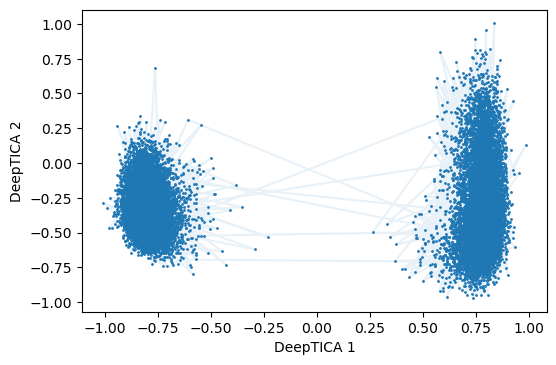

In [16]:
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(s[:,0],s[:,1],s=1,alpha=0.5)
plt.plot(s[:,0],s[:,1],alpha=0.1)
plt.xlabel('DeepTICA 1')
plt.ylabel('DeepTICA 2')
plt.show()

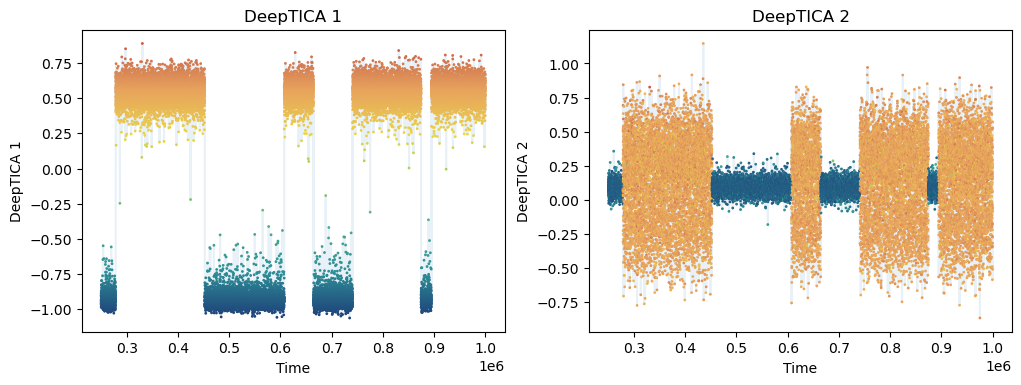

In [17]:
# Predict the values of the DeepTICA CVs along the initial trajectory
with torch.no_grad():
    #input = torch.Tensor(_____FILL____)
    input = torch.Tensor(colvar.filter(regex='d_').values)
    s = model(input).cpu().numpy()

fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,4),dpi=100)

if n_eig == 1 :
    axs = [axs]

for i in range(n_eig):
    ax = axs[i]
    ax.set_title(f'DeepTICA {i+1}')
    if n_eig == 2:
        if i == 0:
            c = s[:,0]
        else:
            c = s[:,0]
        ax.scatter(colvar['time'],s[:,i],c=c,s=1,cmap='fessa')
    else:
        ax.scatter(colvar['time'],s[:,i],s=1)
    ax.plot(colvar['time'],s[:,i],alpha=0.1)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'DeepTICA {i+1}')

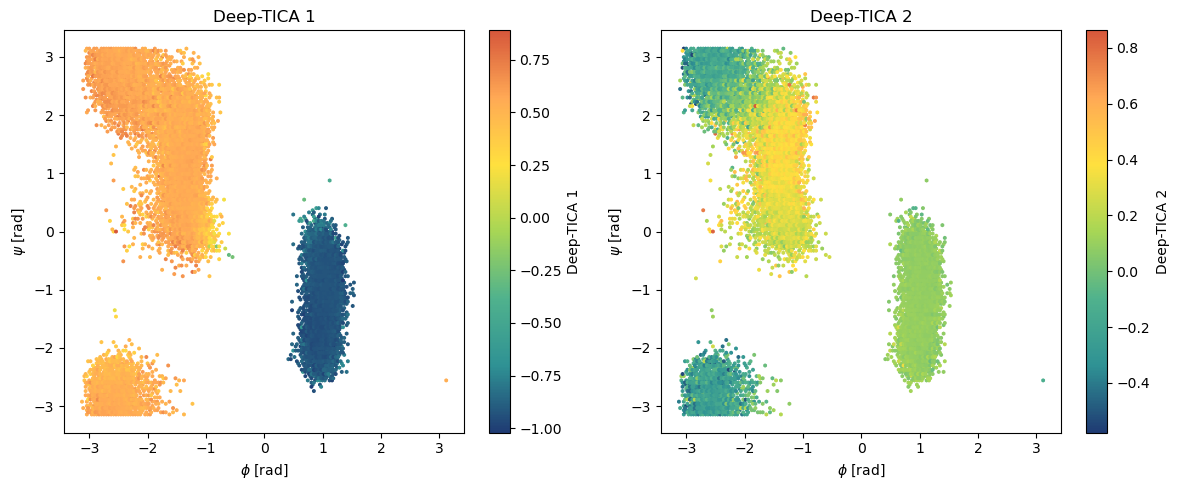

In [18]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

if n_eig ==1:
    axs = [axs]
    
x = colvar['phi'].values
y = colvar['psi'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

Features relevance

/tmp/ipykernel_3241002/550356923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(input_names,fontsize=9)


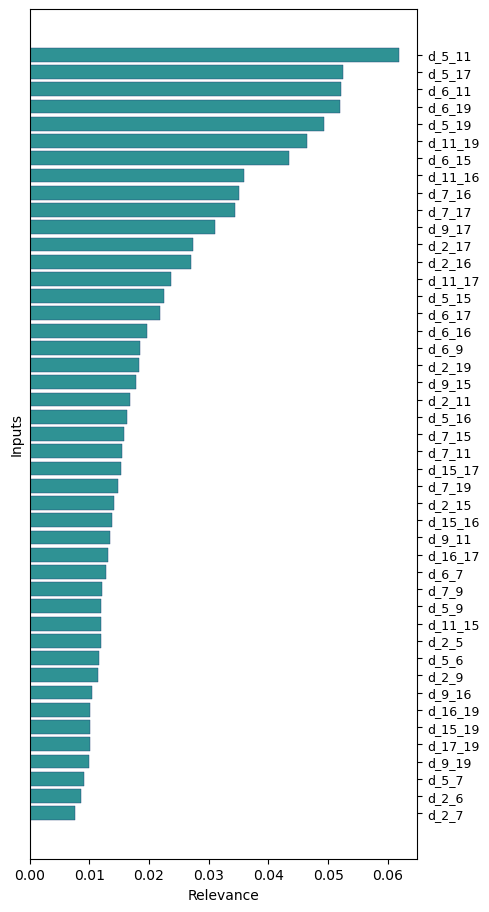

In [19]:
# parameters
multiply_by_stddev = True #whether to multiply derivatives by std dev of inputs
order_by_importance = True #plot results ordered by importance

#input names 
input_names = colvar.filter(regex='d_').columns.values
n_input = len(input_names)

#init arrays
in_num=np.arange(n_input)
rank=torch.zeros(n_input)

#compute input std dev
if multiply_by_stddev:
    in_std=torch.std(torch.Tensor(X),axis=0).numpy()

#compute the derivatives of the outputs w.r.t. inputs over all training set
for x_i in X:    
    x_i = torch.Tensor(x_i)
    x_i.requires_grad=True
    # calculate cv 
    s_i = model(x_i)[0]
    # calculate derivatives
    grad_i = torch.autograd.grad(s_i,x_i)
    # accumulate them
    rank += grad_i[0].abs()

rank = rank.numpy()

#multiply by std dev
if multiply_by_stddev:
    rank = rank * in_std

#normalize to 1
rank/= np.sum(rank)

#sort
if order_by_importance:
    index= rank.argsort()
    input_names = input_names[index]
    rank = rank[index]

#plot
fig=plt.figure(figsize=(5,0.25*n_input), dpi=100)
ax = fig.add_subplot(111)

if order_by_importance:
    ax.barh(in_num, rank,color='fessa1',edgecolor = 'fessa0',linewidth=0.3)
    ax.set_yticklabels(input_names,fontsize=9)
else:
    ax.barh(in_num[::-1], rank[::-1],color='fessa1',edgecolor = 'fessa0',linewidth=0.3)
    ax.set_yticklabels(input_names[::-1],fontsize=9)

ax.set_xlabel('Relevance')
ax.set_ylabel('Inputs')
ax.set_yticks(in_num)
ax.yaxis.tick_right()

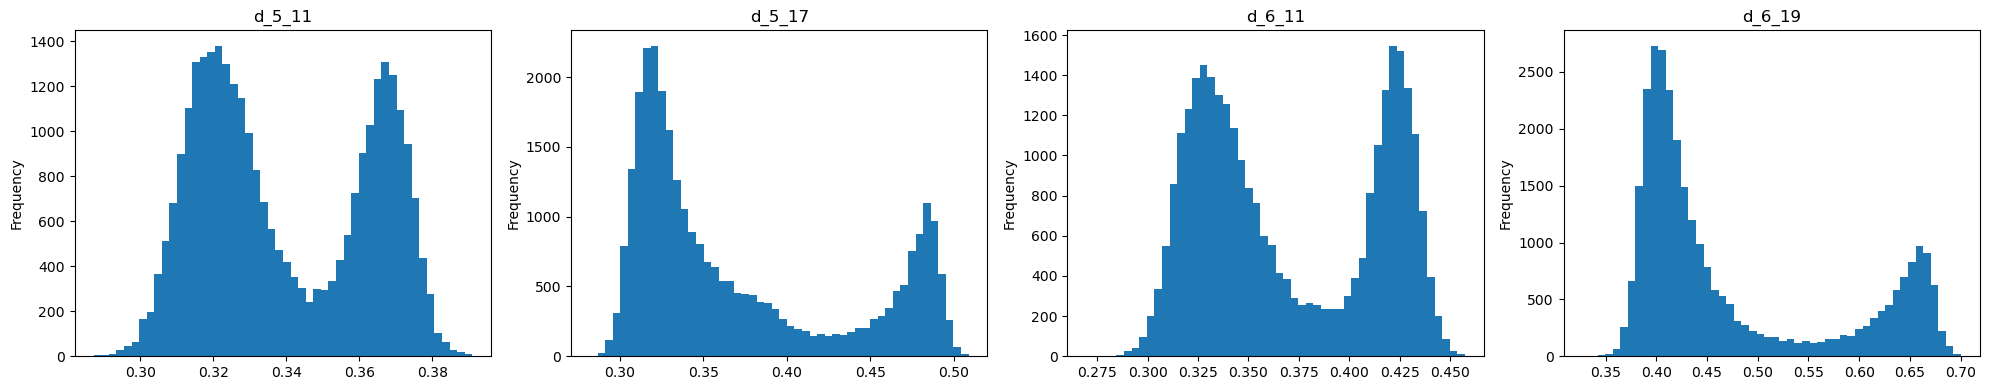

In [21]:
n = 4

fig, axs = plt.subplots(1,n,figsize=(n*5,4),dpi=100)

for i in range(n):
    ax = axs[i]
    name = input_names[::-1][i]
    colvar[name].plot.hist(bins=50,ax=ax,legend=False)
    ax.set_title(name)

plt.tight_layout()

Choice of lag-time

In [22]:
# SOLUTION

lag_times = [0.1,1,10,100,1000]
models = []

#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = 2

lrate             = 1e-3
l2_reg            = 0.

num_epochs        = 1000
earlystop         = True
es_patience       = 10
es_min_delta      = 0.001

log_every         = 10
#--------------------------------------

for lag_time in lag_times:
    print('=================')
    print(f'>> lag_time: {lag_time}')
    print('=================')
    # create dataset
    dataset = create_time_lagged_dataset(X,t=t, lag_time=lag_time, logweights=logweight)
    # split train/valid
    n_train  = int( 0.8 * len(dataset) )
    n_valid  = len(dataset) - n_train
    train_data = Subset(dataset, np.arange(n_train))
    valid_data = Subset(dataset, np.arange(n_train,n_train+n_valid))
    train_loader = FastTensorDataLoader(train_data)
    valid_loader = FastTensorDataLoader(valid_data)
    # define model 
    mod = DeepTICA_CV(nodes)
    opt = torch.optim.Adam(mod.parameters(), lr=lrate, weight_decay=l2_reg)
    mod.set_optimizer(opt)
    mod.set_earlystopping(patience=es_patience,min_delta=es_min_delta, log=False)
    # train
    mod.fit(train_loader,valid_loader, loss_type='sum', n_eig=n_eig, log_every=500)
    models.append(mod)

>> lag_time: 0.1
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
26    -1.995      -1.994      1.000  0.995  
>> lag_time: 1
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
34    -1.952      -1.951      0.999  0.953  
>> lag_time: 10
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
72    -1.530      -1.518      0.991  0.539  
>> lag_time: 100
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
72    -1.049      -0.990      0.982  0.066  
>> lag_time: 1000
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
63    -0.995      -0.921      0.957  0.037  


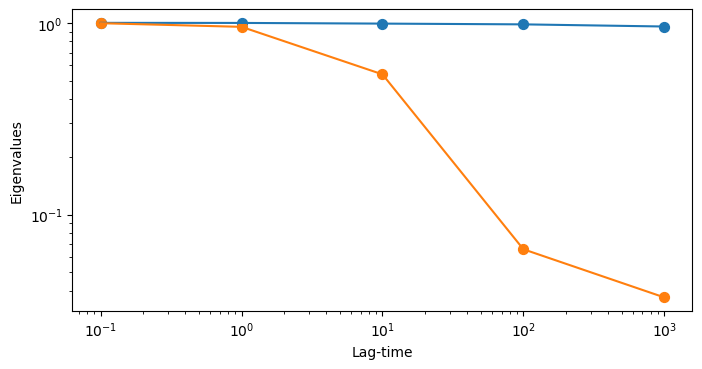

In [23]:
# retrieve final eigenvalues from each model and implied timescales
evals = []
timescales = []

for lag,mod in zip(lag_times,models): 
    with torch.no_grad():
        evals.append(mod.tica.evals_.detach().numpy())
        timescales.append(mod.tica.timescales(lag).numpy())
    
evals = np.asarray(evals)
timescales = np.asarray(timescales)

# plot eigenvalues vs lag_time
fig,ax = plt.subplots(figsize=(8,4),dpi=100)

for i in range(n_eig):
    ax.plot(lag_times,evals[:,i],label='Eig. '+str(i+1))
    ax.scatter(lag_times,evals[:,i],s=50)
    ax.set_ylabel('Eigenvalues')
    ax.set_xlabel('Lag-time')
    ax.set_xscale('log')
    ax.set_yscale('log')


Now let's go back and train a model to approximate only the slowest DeepTICA 1 CV, which we will will use in the next step to enhance sampling.

### 2. Bias Deep-TICA 1

Once we have analyzed the initial simulation and extracted the slow modes into the DeepTICA CVs, we can perform a new OPES simulation biasing the leading DeepTICA 1 CV, in addition to the bias from the previous simulation (static).     

In [28]:
folder = '2_DeepTICA/1_psi/2_deeptica1/'
Path(folder).mkdir(parents=True, exist_ok=True)
execute(f"cp ../../md_inputs/input* .", folder=folder)

# export model
model.export(folder)

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute descriptors
INCLUDE FILE=../../plumed-distances.dat

# Compute DeepTICA CVs
deep: PYTORCH_MODEL FILE=model.ptc ARG=d_2_5,d_2_6,d_2_7,d_2_9,d_2_11,d_2_15,d_2_16,d_2_17,d_2_19,d_5_6,d_5_7,d_5_9,d_5_11,d_5_15,d_5_16,d_5_17,d_5_19,d_6_7,d_6_9,d_6_11,d_6_15,d_6_16,d_6_17,d_6_19,d_7_9,d_7_11,d_7_15,d_7_16,d_7_17,d_7_19,d_9_11,d_9_15,d_9_16,d_9_17,d_9_19,d_11_15,d_11_16,d_11_17,d_11_19,d_15_16,d_15_17,d_15_19,d_16_17,d_16_19,d_17_19

# Apply OPES bias (combine with the static bias equal to the one obtained at the end of the first simulation)
static: OPES_METAD RESTART=YES FILE=KERNELS_PSI ARG=psi BARRIER=40 SIGMA=0.15 PACE=50000000 STATE_RFILE=../1_opes-psi/STATE_PSI
opes: OPES_METAD ARG=deep.node-0 BARRIER=40 PACE=500 STATE_WFILE=STATE

# Print 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=5000000

clean(folder)
#execute(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps} > alanine.out", folder=folder)

Completed: cp ../../md_inputs/input* .


rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'DELTAFS': No such file or directory


Once the calculation is over we can analyze the trajectory as in the previous tutorial. First we look at the time evolution of the DeepTICA CV along the trajectory, as well as plotting the Ramachandran plot to see the explored space.

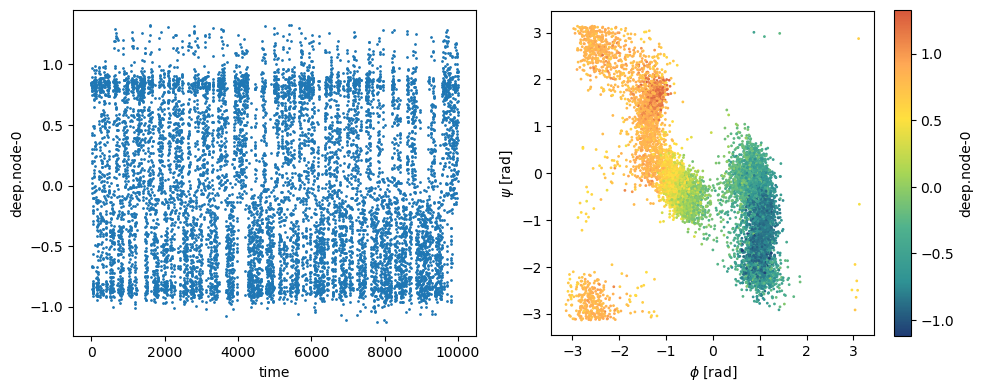

In [59]:
folder = '2_DeepTICA/1_psi/2_deeptica1/'
colvar = load_dataframe(folder+'COLVAR')

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=100)
# Time evolution (DeepTICA)
colvar.plot.scatter('time','deep.node-0',s=1,ax=axs[0])
axs[1].set_xlabel('Time [ps]')
axs[1].set_ylabel('DeepTICA 1')
# 2D scatter plot colored with DeepTICA
colvar.plot.scatter('phi','psi',c='deep.node-0',s=1,cmap='fessa',ax=axs[1])
axs[1].set_xlabel(r'$\phi$ [rad]')
axs[1].set_ylabel(r'$\psi$ [rad]')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

(0.0, 50.0)

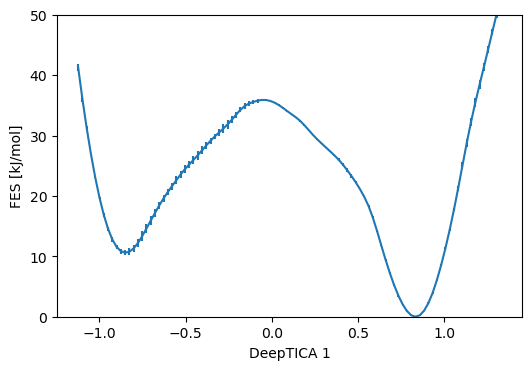

In [60]:
from mlcvs.utils.fes import compute_fes

s = colvar['deep.node-0'].values

# compute weights
kbT = 2.5
w = np.exp(colvar.filter(regex='.bias').values.sum(axis=1)/kbT)

fig,ax = plt.subplots(figsize=(6,4),dpi=100)
fes,grid,bounds,error = compute_fes(s, weights=w, kbt=kbT, 
                                    blocks=2, bandwidth=0.04, 
                                    plot=True, ax = ax)
ax.set_xlabel('DeepTICA 1')
ax.set_ylabel('FES [kJ/mol]')
ax.set_ylim(0,50)

Also in this tutorial we can compute the correlation with a set of physical descriptors, to obtain a physical insight.

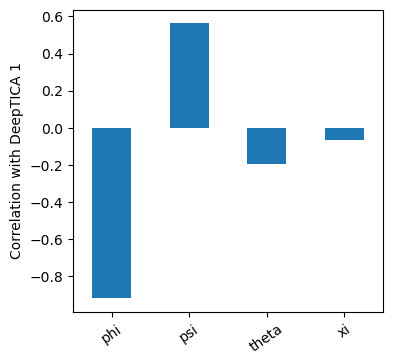

In [61]:
# select deeptica and input distances, as well as dihedral angles
cols = ['deep.node-0', 'phi', 'psi', 'theta', 'xi' ]

# compute correlation
corr = colvar[cols].corr(method='pearson')

# plot
fig,ax = plt.subplots(figsize=(4,4),dpi=100)
corr['deep.node-0'].drop('deep.node-0').plot(kind='bar', ax=ax, rot=35)
ax.set_ylabel('Correlation with DeepTICA 1')
plt.show()

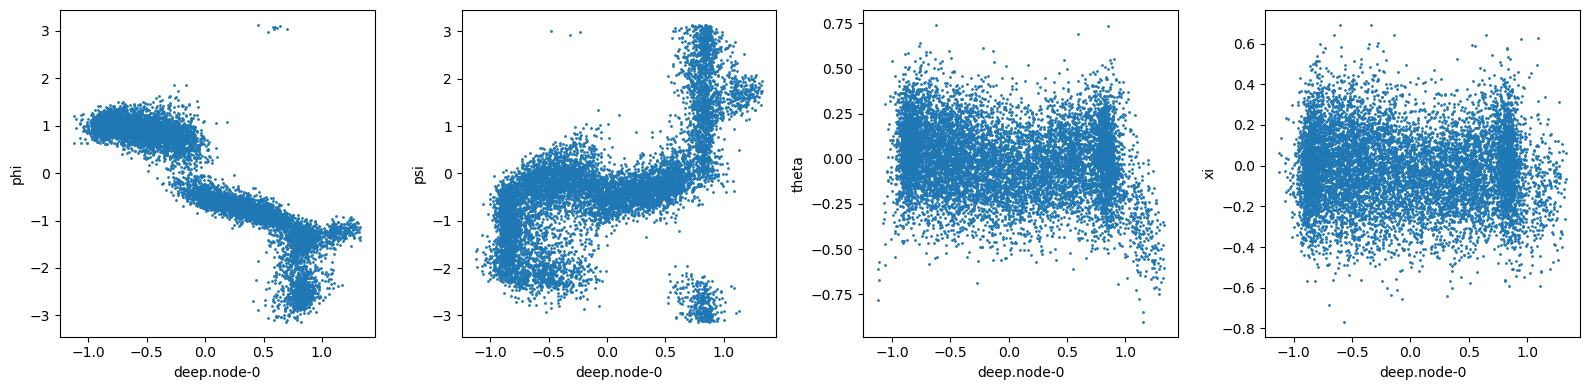

In [62]:
fig,axs = plt.subplots(1,len(cols)-1,figsize=(16,4),dpi=100)

for i,desc in enumerate(cols[1:]):
    colvar.plot.scatter('deep.node-0',desc,s=1,ax=axs[i],cmap='fessa',colorbar=False)

plt.tight_layout()

### 3. Bonus: bias Deep-TICA 1 alone

As discussed in the introduction, the DeepTICA CVs that we find are connected to the slow modes of the initial biased simulation. So in general it is appropriate to accelerate them together with the bias used in the first run. You can try to see what happens if you bias only the DeepTICA 1 CV.

In [72]:
folder = '2_DeepTICA/1_psi/3_deeptica1_alone/'
Path(folder).mkdir(parents=True, exist_ok=True)
execute(f"cp ../../md_inputs/input* .", folder=folder)

# export model
#model.export(folder)
execute(f"cp ../2_deeptica1/model* .", folder=folder)

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute descriptors
INCLUDE FILE=../../plumed-distances.dat

# Compute DeepTICA CVs
deep: PYTORCH_MODEL FILE=model.ptc ARG=d_2_5,d_2_6,d_2_7,d_2_9,d_2_11,d_2_15,d_2_16,d_2_17,d_2_19,d_5_6,d_5_7,d_5_9,d_5_11,d_5_15,d_5_16,d_5_17,d_5_19,d_6_7,d_6_9,d_6_11,d_6_15,d_6_16,d_6_17,d_6_19,d_7_9,d_7_11,d_7_15,d_7_16,d_7_17,d_7_19,d_9_11,d_9_15,d_9_16,d_9_17,d_9_19,d_11_15,d_11_16,d_11_17,d_11_19,d_15_16,d_15_17,d_15_19,d_16_17,d_16_19,d_17_19

# Apply OPES bias
opes: OPES_METAD ARG=deep.node-0 BARRIER=40 PACE=500 STATE_WFILE=STATE

# Print 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=5000000

clean(folder)
#execute(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps} > alanine.out", folder=folder)

Completed: cp ../../md_inputs/input* .
Completed: cp ../2_deeptica1/model* .


rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'COLVAR*': No such file or directory
rm: cannot remove 'KERNELS*': No such file or directory
rm: cannot remove 'STATE*': No such file or directory
rm: cannot remove 'DELTAFS': No such file or directory
rm: cannot remove 'alanine*': No such file or directory


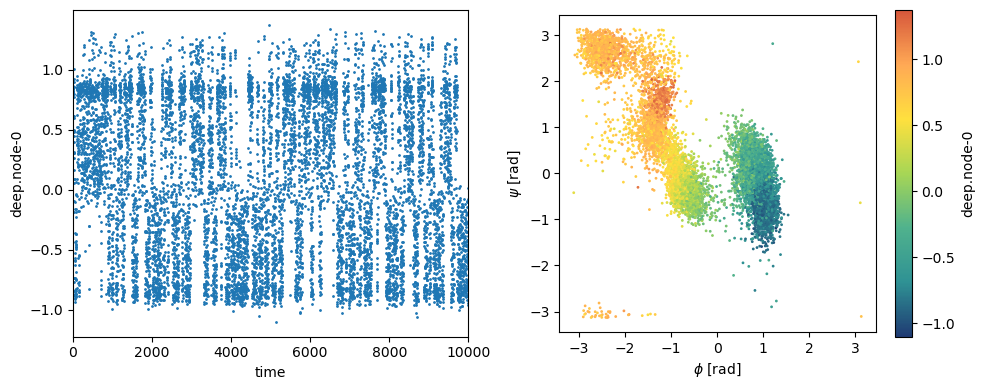

In [106]:
folder = '2_DeepTICA/1_psi/3_deeptica1_alone/'
colvar = load_dataframe(folder+'COLVAR')

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=100)
# Time evolution (DeepTICA)
colvar.plot.scatter('time','deep.node-0',s=1,ax=axs[0],cmap='fessa')
axs[1].set_xlabel('Time [ps]')
axs[1].set_ylabel('DeepTICA 1')
# 2D scatter plot colored with DeepTICA
colvar['bias']=colvar.filter(regex='.bias').sum(axis=1)
colvar.plot.scatter('phi','psi',c='deep.node-0',s=1,cmap='fessa',ax=axs[1])
axs[1].set_xlabel(r'$\phi$ [rad]')
axs[1].set_ylabel(r'$\psi$ [rad]')
axs[1].set_aspect('equal')
axs[0].set_xlim(0,10000)

plt.tight_layout()
plt.show()

## 2.2 Deep-TICA CVs from a multithermal simulation

In this second exercise we want to learn the CVs from a different kind of simulation. Instead of performing the initial simulation biasing another CV, we resort to a multithermal simulation.
This amount to sampling the configurations relevant to a set of temperatures, and it is the same ensemble simulated with parallel tempering/replica exchange methods. However, with OPES we can perform such simulation with a single replica by biasing the potential energy. See also the Masterclass 22.03 to learn more.

This approach has the advantage that we do not have to start with a guess of a CV in the first place.

### 1. Initial simulation: multithermal

Also in this case you can find already a multicanonical simulation in the folder, performed with the following input file.

In [31]:
folder = '2_DeepTICA/2_multithermal/1_multi/'
Path(folder).mkdir(parents=True, exist_ok=True)
execute(f"cp ../md_inputs/input* .", folder=folder)

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute descriptors
INCLUDE FILE=../../plumed-distances.dat

# Define multithermal bias
ecv: ECV_MULTITHERMAL ARG=ene TEMP_MAX=600
opes: OPES_EXPANDED ARG=ecv.ene PACE=500

# Print 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=25000000 #50ns

#clean(folder)
#execute(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps}", folder=folder)

cp: cannot stat '../md_inputs/input*': No such file or directory



The multithermal simulation is much more efficient than the previous $\psi$-based simulation. Still, the sampling is far from optimal. 

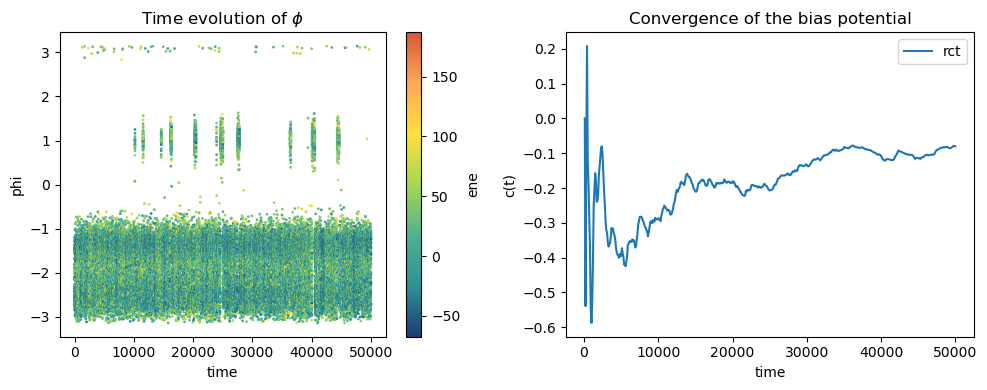

In [32]:
folder = '2_DeepTICA/2_multithermal/1_multi/'
colvar = load_dataframe(folder+'COLVAR')
deltafs = load_dataframe(folder+'DELTAFS')

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=100)
# Time evolution (phi)
colvar.plot.scatter('time','phi',c='ene',s=1,ax=axs[0],cmap='fessa')
axs[0].set_title('Time evolution of $\phi$')
# c(t) evolution
deltafs.plot('time','rct',ax=axs[1])
axs[1].set_title('Convergence of the bias potential')
axs[1].set_ylabel('c(t)')
plt.tight_layout()

### Train DeepTICA CVs

In [33]:
# Load files
folder = '2_DeepTICA/2_multithermal/1_multi/'
colvar = load_dataframe(folder+'COLVAR',start=15000) #discard first 15 ns

# Select descriptors
X = colvar.filter(regex='d_').values
n_input = X.shape[1]

print(X.shape)

(35001, 45)


**Compute weights for time rescaling**

Since the initial simulation is performed in the multicanonical ensemble, we need to reweight the points in a different way.

We first extract the time $t$, the energy $E$ (needed for the multicanonical reweight [1]) and the bias $V$ from the COLVAR file. We then calculate the weights as:

$$ w = e^{\beta\ V + (\beta_0-\beta)\ E} $$

NB: if simulation temperature $\beta_0$ is equal to the reweighting one $\beta$ the multicanonical reweight coincides with the standard umbrella sampling-like case.

Once we have computed the weights, we rescale the time as before by usingas before using: $ dt'_k = w_k\ dt $.


[1] Invernizzi, Piaggi, and Parrinello. "Unified approach to enhanced sampling." _Physical Review X_ 10.4 (2020): 041034.


In [34]:
#------------- PARAMETERS -------------
multicanonical    = True        #using a standard reweight (false) or a multicanonical one (true)
temp              = 300.        #reweighting temperature
temp0             = 300.        #simulation temperature (only needed if multicanonical == True)
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)
beta0=1./(kb*temp0)

# Extract cvs from df

t = colvar['time'].values # save time
ene = colvar['ene'].values.astype(np.float64) # store energy as long double
bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweight = beta*bias

if multicanonical:
    ene -= np.mean(ene) #first shift energy by its mean value
    logweight += (beta0-beta)*ene

Create dataset of time-lagged configurations

In [35]:
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from torch.utils.data import Subset,random_split

lag_time = 1.0

# create dataset
dataset = create_time_lagged_dataset(X,t=t,
                                       lag_time=lag_time,
                                       logweights=logweight)

n_train  = int( 0.8 * len(dataset) )
n_valid  = len(dataset) - n_train
train_data, valid_data = random_split(dataset,[n_train,n_valid]) 

# create dataloaders 
train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

Time-lagged pairs:	 63650
Training data:		 50920
Validation data:	 12730


This time we will optimize directly two DeepTICA CVs.

In [36]:
from mlcvs.tica import DeepTICA_CV

#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = 2

lrate             = 1e-3
l2_reg            = 0.

num_epochs        = 1000
earlystop         = True
es_patience       = 10
es_consecutive    = False

log_every         = 10
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(nodes)
model.to(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)

# REGULARIZATION
model.set_optimizer(opt)
model.set_earlystopping(patience=es_patience,min_delta=0.,consecutive=es_consecutive, save_best_model=True, log=False)

# TRAIN
model.fit(train_loader,valid_loader,
            standardize_inputs=True,
            standardize_outputs=True,
            loss_type=loss_type,
            n_eig=n_eig,
            nepochs=num_epochs,
            info=False, log_every=log_every)

Epoch Train Loss  Valid Loss  Eigenvalues             
10    -0.270      -0.243      0.515  0.007  
20    -0.294      -0.269      0.540  0.013  
30    -0.313      -0.288      0.557  0.027  
40    -0.336      -0.311      0.576  0.041  
50    -0.419      -0.400      0.621  0.090  
60    -1.050      -1.076      0.875  0.493  
70    -1.184      -1.204      0.944  0.536  
80    -1.221      -1.237      0.957  0.550  
90    -1.250      -1.262      0.964  0.563  
100   -1.276      -1.285      0.969  0.578  
110   -1.299      -1.302      0.973  0.592  
120   -1.314      -1.309      0.976  0.600  
130   -1.325      -1.312      0.979  0.605  
140   -1.335      -1.313      0.981  0.609  
INFO: Early stopping
145   -1.339      -1.313      0.982  0.611  


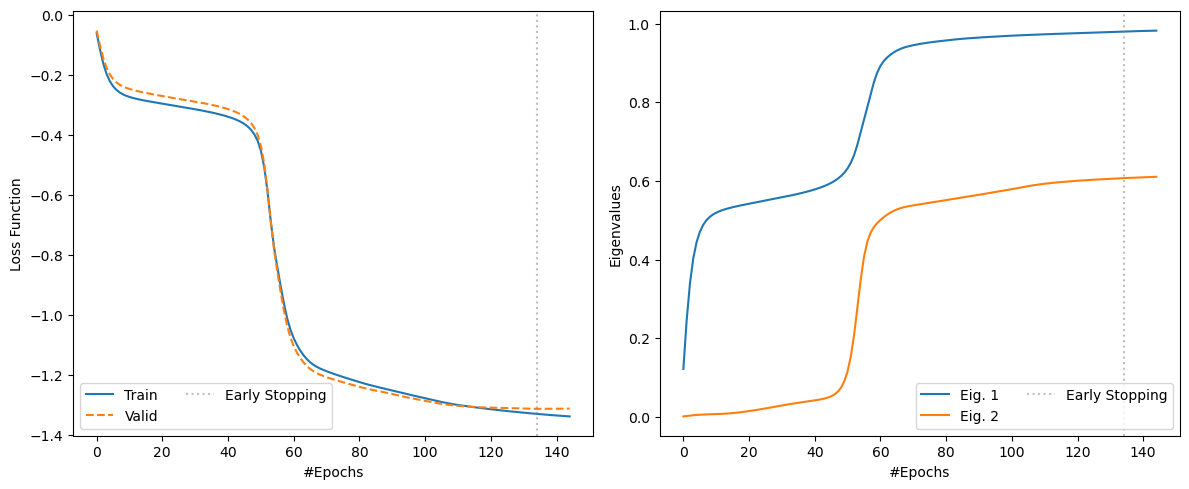

In [37]:
fig, axs = plt.subplots(1,2,figsize=(12,5),dpi=100)

loss_train = [x.cpu() for x in model.loss_train]
loss_valid = [x.cpu() for x in model.loss_valid]

# Loss function
ax = axs[0]
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

# Eigenvalues vs epoch
ax = axs[1]
with torch.no_grad():
    evals_train = np.asarray(torch.cat(model.evals_train).cpu())
for i in range(n_eig):
    ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
ax.set_ylabel('Eigenvalues')

# Common setup
for ax in axs:
    if model.earlystopping_.early_stop:
        ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
        ax.set_xlabel('#Epochs')
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()

**Questions**:

- Is the choice of lag-time appropriate to recover not only the slowest CV but also the second one? How are the results changing if you change the lag-time?
- Can we understand something more about the second DeepTICA 2 CV in this case? Do you have any idea why?

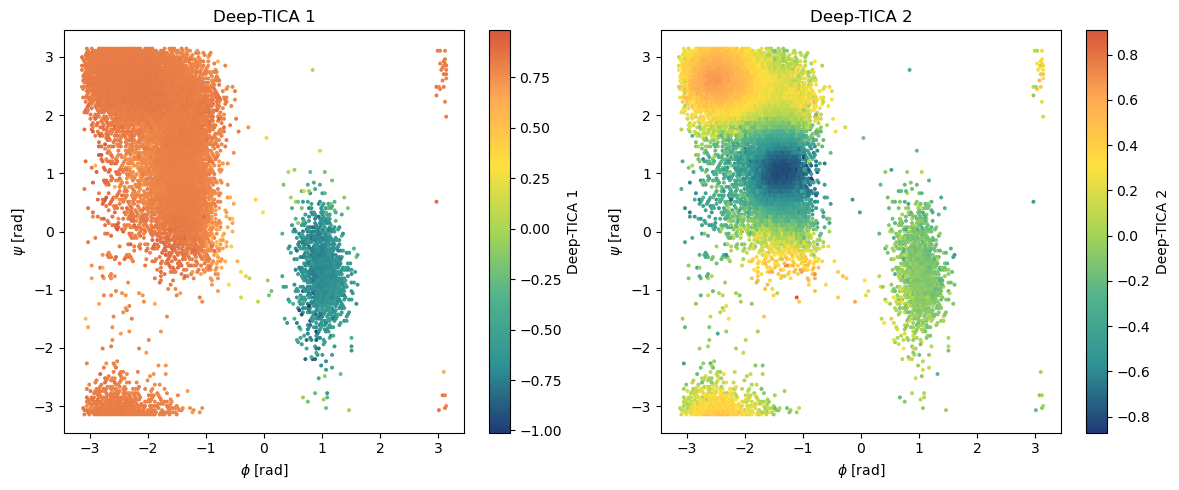

In [39]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

x = colvar['phi'].values
y = colvar['psi'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

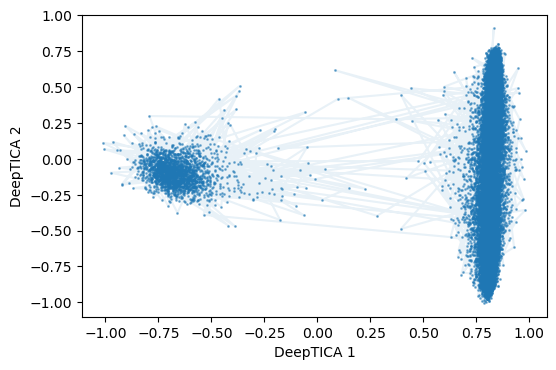

In [48]:
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(s[:,0],s[:,1],s=1,alpha=0.5)
plt.plot(s[:,0],s[:,1],alpha=0.1)
plt.xlabel('DeepTICA 1')
plt.ylabel('DeepTICA 2')
plt.show()

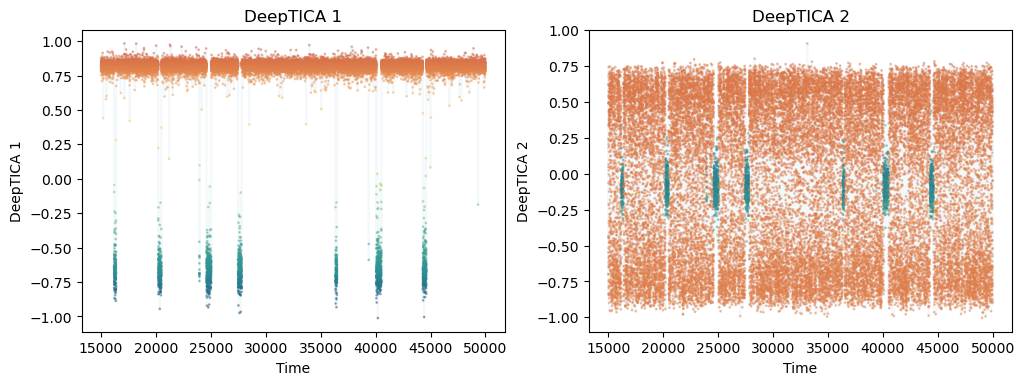

In [45]:
# Predict the values of the DeepTICA CVs along the initial trajectory
with torch.no_grad():
    #input = torch.Tensor(_____FILL____)
    input = torch.Tensor(colvar.filter(regex='d_').values)
    s = model(input).cpu().numpy()

fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,4),dpi=100)

if n_eig == 1 :
    axs = [axs]

for i in range(n_eig):
    ax = axs[i]
    ax.set_title(f'DeepTICA {i+1}')
    if n_eig == 2:
        if i == 0:
            c = s[:,0]
        else:
            c = s[:,0]
        ax.scatter(colvar['time'],s[:,i],c=c,s=1,cmap='fessa',alpha=0.4)
    else:
        ax.scatter(colvar['time'],s[:,i],s=1)
    ax.plot(colvar['time'],s[:,i],alpha=0.05)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'DeepTICA {i+1}')

What do we learn if we compute the FES along the extracted DeepTICA CVs?

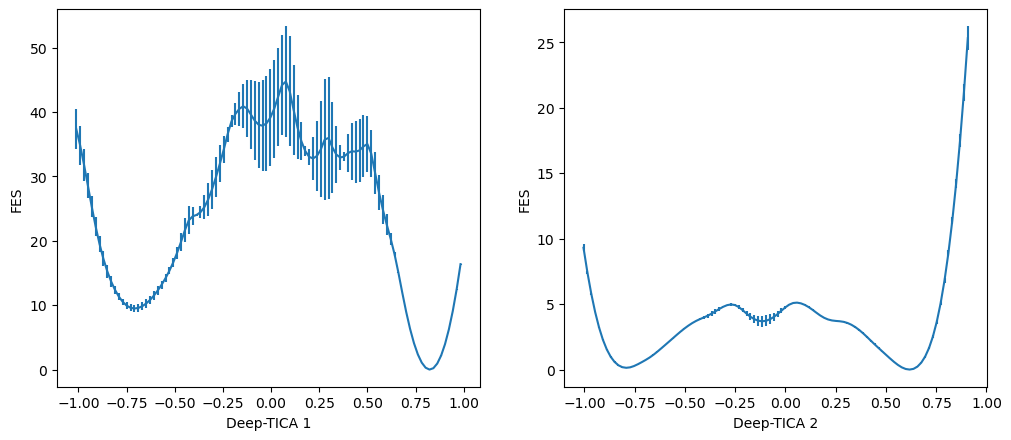

In [46]:
from mlcvs.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

for i in range(n_eig):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        blocks=2,
                                        bandwidth=0.02,scale_by='range',
                                        plot=True, plot_max_fes=100, ax = axs[i])
    axs[i].set_xlabel('Deep-TICA '+str(i+1))

To get a better insight on the second variable, we can compute the FES using only the points in the right basin. This is related to the hierarchical structure of the eigenfunctions of the transfer operator.

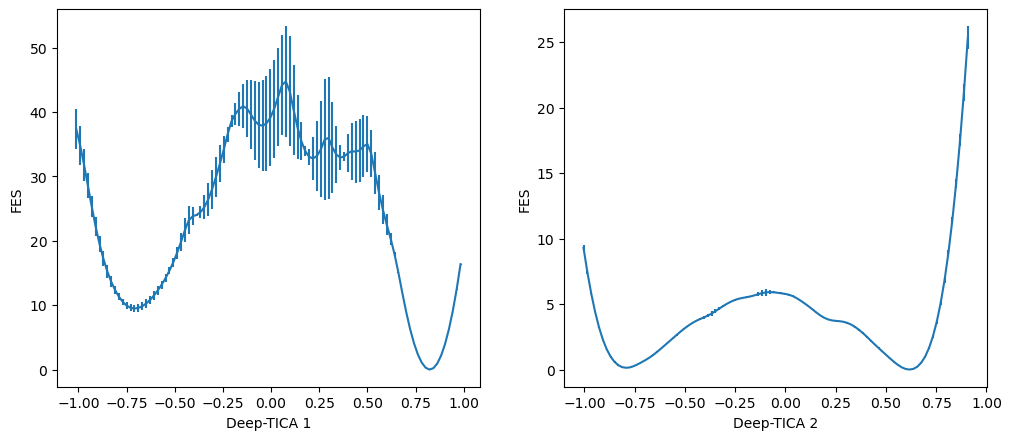

In [50]:
from mlcvs.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

cv, w = [], []
# Dtica 1
dtica1 = s[:,0]
cv.append(dtica1)
w.append(np.exp(logweight))
# Dtica 2
dtica2 = s[:,1]
mask = dtica1>0
dtica2 = dtica2[mask]
cv.append(dtica2)
w.append(np.exp(logweight)[mask])

for i in range(n_eig):
    fes,grid,bounds,error = compute_fes(cv[i], weights=w[i],
                                        blocks=2,
                                        bandwidth=0.02,scale_by='range',
                                        plot=True, plot_max_fes=100, ax = axs[i])
    axs[i].set_xlabel('Deep-TICA '+str(i+1))

Choice of the lag-time

In [106]:
# SOLUTION

lag_times = [0.01,0.1,1,10]
models = []

#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = 2

lrate             = 1e-3
l2_reg            = 0.

num_epochs        = 1000
earlystop         = True
es_patience       = 10
es_min_delta      = 0.001

log_every         = 10
#--------------------------------------

for lag_time in lag_times:
    print('=================')
    print(f'>> lag_time: {lag_time}')
    print('=================')
    # create dataset
    dataset = create_time_lagged_dataset(X,t=t, lag_time=lag_time, logweights=logweight)
    # split train/valid
    n_train  = int( 0.8 * len(dataset) )
    n_valid  = len(dataset) - n_train
    train_data = Subset(dataset, np.arange(n_train))
    valid_data = Subset(dataset, np.arange(n_train,n_train+n_valid))
    train_loader = FastTensorDataLoader(train_data)
    valid_loader = FastTensorDataLoader(valid_data)
    # define model 
    mod = DeepTICA_CV(nodes)
    opt = torch.optim.Adam(mod.parameters(), lr=lrate, weight_decay=l2_reg)
    mod.set_optimizer(opt)
    mod.set_earlystopping(patience=es_patience,min_delta=es_min_delta, log=False)
    # train
    mod.fit(train_loader,valid_loader, loss_type='sum', n_eig=n_eig, log_every=500)
    models.append(mod)

>> lag_time: 0.01
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
43    -1.993      -1.993      0.999  0.994  
>> lag_time: 0.1
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
118   -1.950      -1.949      0.997  0.953  
>> lag_time: 1
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
270   -1.609      -1.586      0.985  0.624  
>> lag_time: 10
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
111   -0.993      -0.941      0.917  0.074  


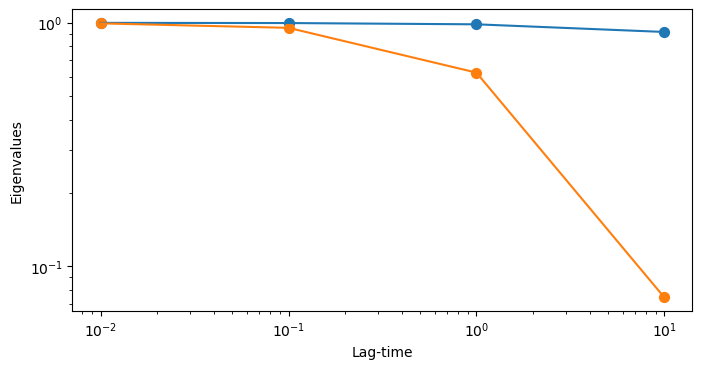

In [107]:
# retrieve final eigenvalues from each model and implied timescales
evals = []
timescales = []

for lag,mod in zip(lag_times,models): 
    with torch.no_grad():
        evals.append(mod.tica.evals_.detach().numpy())
        timescales.append(mod.tica.timescales(lag).numpy())
    
evals = np.asarray(evals)
timescales = np.asarray(timescales)

# plot eigenvalues vs lag_time
fig,ax = plt.subplots(figsize=(8,4),dpi=100)

for i in range(n_eig):
    ax.plot(lag_times,evals[:,i],label='Eig. '+str(i+1))
    ax.scatter(lag_times,evals[:,i],s=50)
    ax.set_ylabel('Eigenvalues')
    ax.set_xlabel('Lag-time')
    ax.set_xscale('log')
    ax.set_yscale('log')

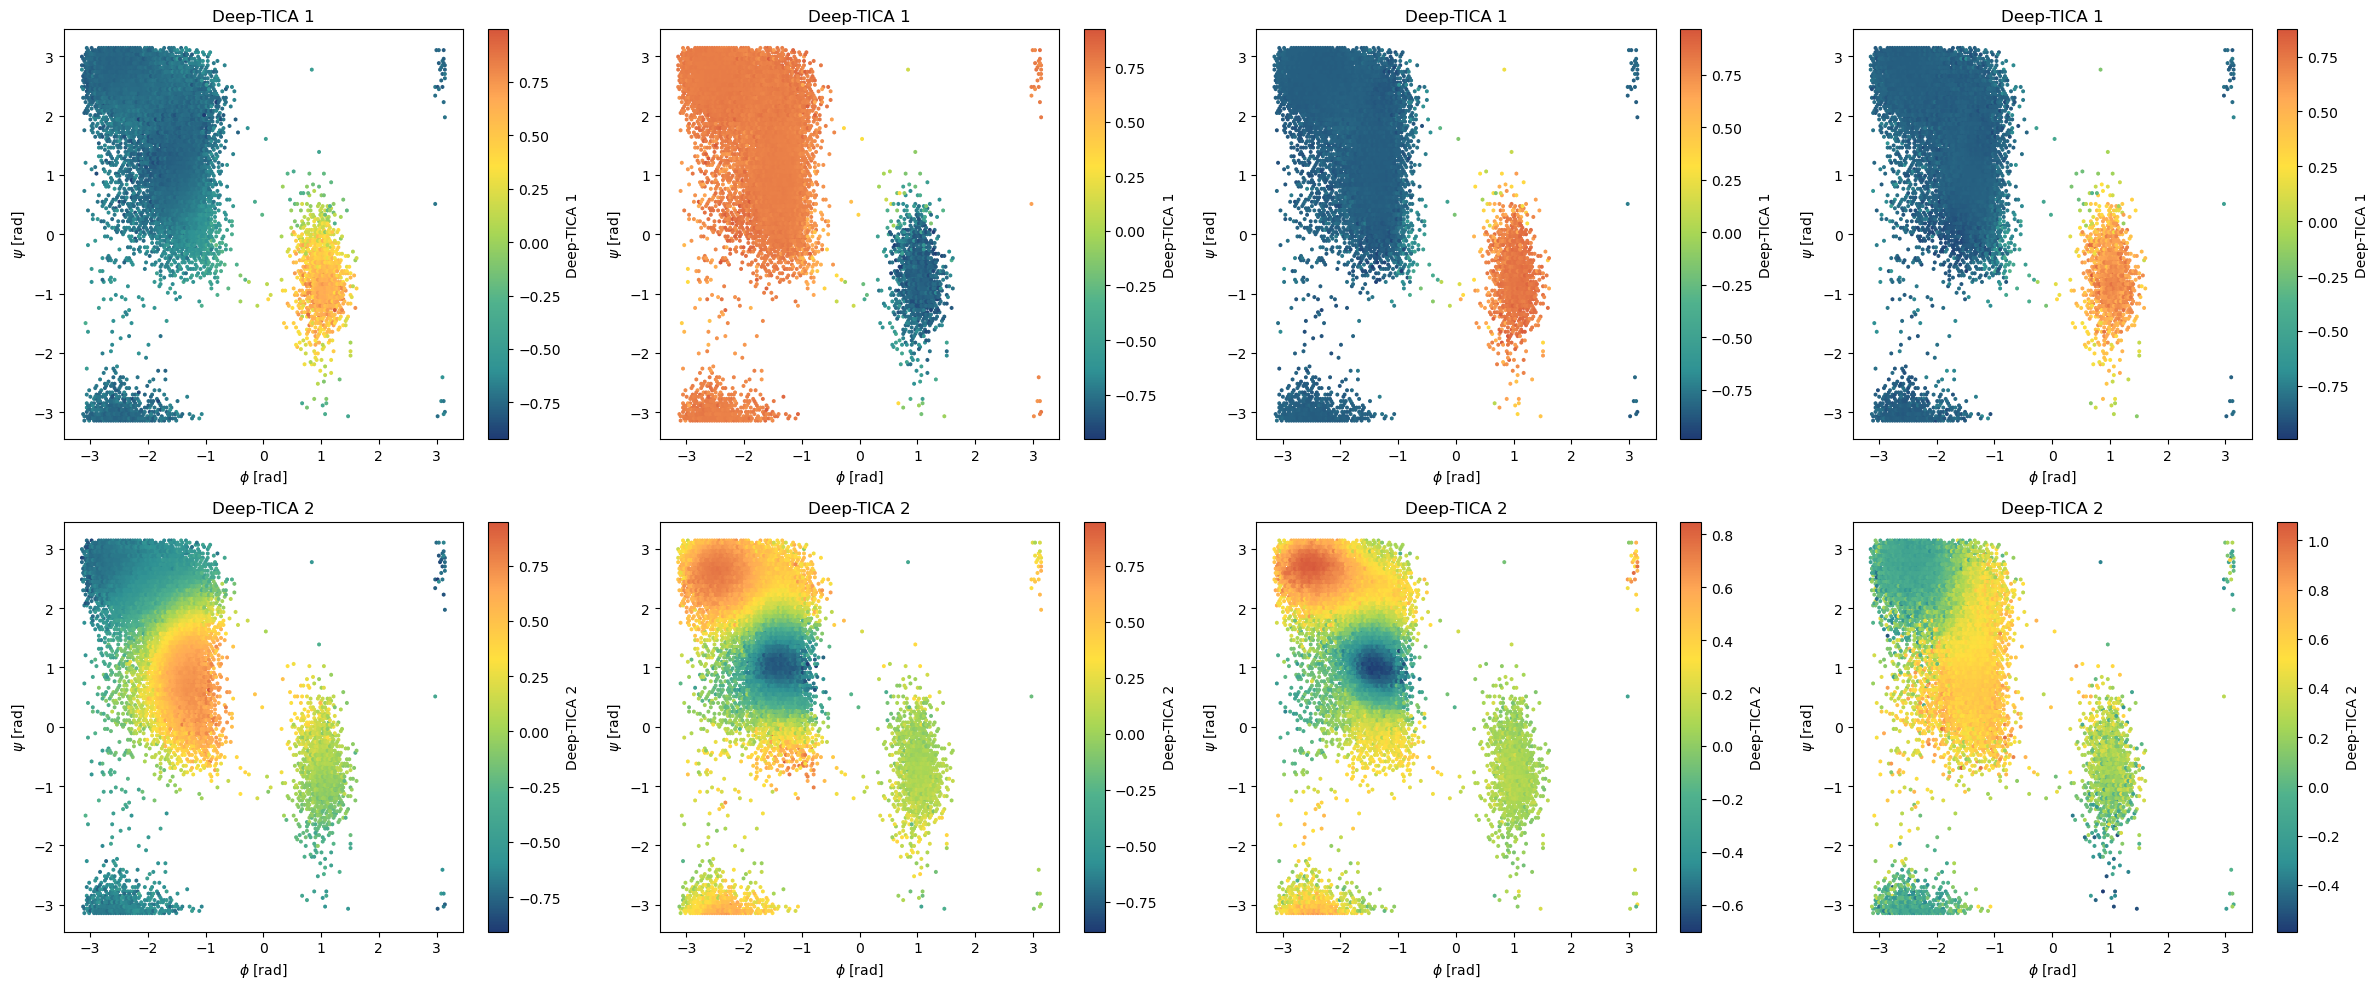

In [109]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(n_eig,len(lag_times),figsize=(6*len(lag_times),5*n_eig),dpi=100)

x = colvar['phi'].values
y = colvar['psi'].values

for j,mod in enumerate(models):

    # compute cvs
    with torch.no_grad():
        s = mod(torch.Tensor(X)).numpy()
        
    for i in range(n_eig):
        ax = axs[i][j]
        pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
        cbar = plt.colorbar(pp,ax=ax)
        ax.set_title('Deep-TICA '+str(i+1))
        ax.set_xlabel(r'$\phi$ [rad]')
        ax.set_ylabel(r'$\psi$ [rad]')
        cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

### 2. Bias DeepTICA 1

Here we bias the slowest DeepTICA CV in the multithermal ensemble. We could do it as before by appling the multithermal bias statically. Instead, we use a multiumbrella ensemble simulation and optimized it together with the multithermal expanded CVs. In this way we show how we can optimize the two together if needed.

In [110]:
folder = '2_DeepTICA/2_multithermal/2_deeptica1/'
Path(folder).mkdir(parents=True, exist_ok=True)
execute(f"cp ../../md_inputs/input* .", folder=folder)

model.export(folder)

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute descriptors
INCLUDE FILE=../../plumed-distances.dat

# Compute DeepTICA CVS
deep: PYTORCH_MODEL FILE=model.ptc ARG=d_2_5,d_2_6,d_2_7,d_2_9,d_2_11,d_2_15,d_2_16,d_2_17,d_2_19,d_5_6,d_5_7,d_5_9,d_5_11,d_5_15,d_5_16,d_5_17,d_5_19,d_6_7,d_6_9,d_6_11,d_6_15,d_6_16,d_6_17,d_6_19,d_7_9,d_7_11,d_7_15,d_7_16,d_7_17,d_7_19,d_9_11,d_9_15,d_9_16,d_9_17,d_9_19,d_11_15,d_11_16,d_11_17,d_11_19,d_15_16,d_15_17,d_15_19,d_16_17,d_16_19,d_17_19

# Define multithermal bias and multiumbrellas on deeptica 1
ecv: ECV_MULTITHERMAL ARG=ene TEMP_MAX=600
umb: ECV_UMBRELLAS_LINE ARG=deep.node-0 SIGMA=0.1 CV_MIN=-1.0 CV_MAX=1.0 BARRIER=35
opes: OPES_EXPANDED ARG=ecv.*,umb.* PACE=500

# Print 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=5000000 #10ns

clean(folder)
#execute(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps}", folder=folder)

Completed: cp ../../md_inputs/input* .


rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'COLVAR*': No such file or directory
rm: cannot remove 'KERNELS*': No such file or directory
rm: cannot remove 'STATE*': No such file or directory
rm: cannot remove 'DELTAFS': No such file or directory
rm: cannot remove 'alanine*': No such file or directory


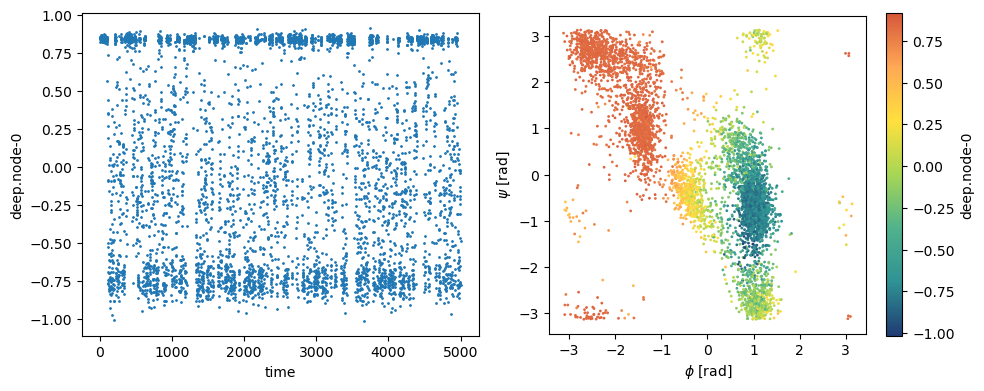

In [70]:
folder = '2_DeepTICA/2_multithermal/2_deeptica1/'
colvar = load_dataframe(folder+'COLVAR')

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=100)
# Time evolution (DeepTICA)
colvar.plot.scatter('time','deep.node-0',s=1,ax=axs[0])
axs[1].set_xlabel('Time [ps]')
axs[1].set_ylabel('DeepTICA 1')
# 2D scatter plot colored with DeepTICA
colvar.plot.scatter('phi','psi',c='deep.node-0',s=1,cmap='fessa',ax=axs[1])
axs[1].set_xlabel(r'$\phi$ [rad]')
axs[1].set_ylabel(r'$\psi$ [rad]')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

To compute the FES we need to reweight the simulation. Similarly to what we have done for computing the time-correlation functions, since there is also a multithermal bias we need to reweight accordingly.

In [125]:
#------------- PARAMETERS -------------
multicanonical    = True        #using a standard reweight (false) or a multicanonical one (true)
temp              = 300.        #reweighting temperature
temp0             = 300.        #simulation temperature (only needed if multicanonical == True)
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)
beta0=1./(kb*temp0)

# Extract cvs from df

t = colvar['time'].values # save time
ene = colvar['ene'].values.astype(np.float64) # store energy as long double
bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweight = beta*bias

if multicanonical:
    ene -= np.mean(ene) #first shift energy by its mean value
    logweight += (beta0-beta)*ene

(0.0, 50.0)

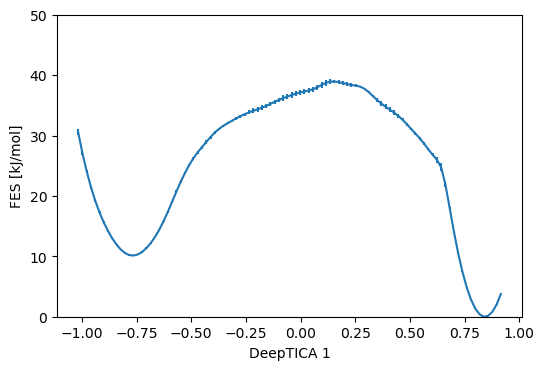

In [126]:
from mlcvs.utils.fes import compute_fes

s = colvar['deep.node-0'].values

# compute weights
kbT = 2.5
w = np.exp(logweight)

fig,ax = plt.subplots(figsize=(6,4),dpi=100)
fes,grid,bounds,error = compute_fes(s, weights=w, kbt=kbT, 
                                    blocks=5, bandwidth=0.04, 
                                    plot=True, ax = ax)
ax.set_xlabel('DeepTICA 1')
ax.set_ylabel('FES [kJ/mol]')
ax.set_ylim(0,50)

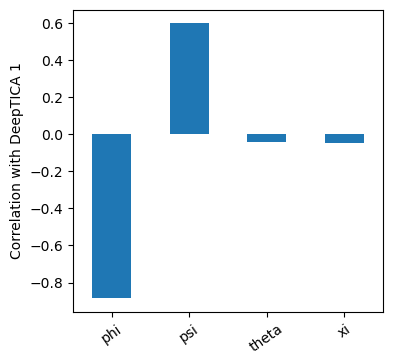

In [127]:
# select deeptica as well as dihedral angles
cols = ['deep.node-0', 'phi', 'psi', 'theta', 'xi' ]

# compute correlation
corr = colvar[cols].corr(method='pearson')

# plot
fig,ax = plt.subplots(figsize=(4,4),dpi=100)
corr['deep.node-0'].drop('deep.node-0').plot(kind='bar', ax=ax, rot=35)
ax.set_ylabel('Correlation with DeepTICA 1')
plt.show()

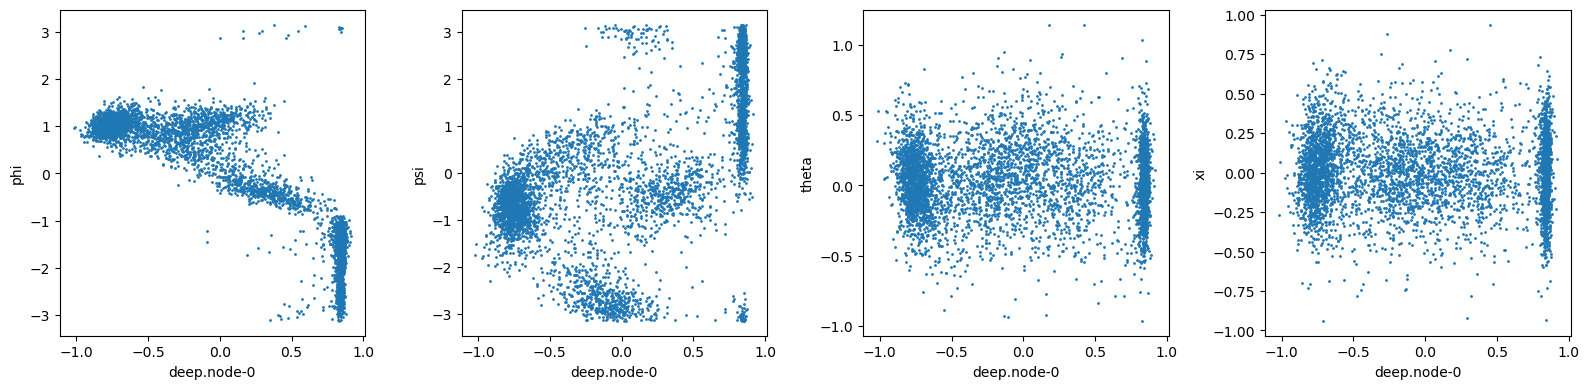

In [128]:
fig,axs = plt.subplots(1,len(cols)-1,figsize=(16,4),dpi=100)

for i,desc in enumerate(cols[1:]):
    colvar.plot.scatter('deep.node-0',desc,s=1,ax=axs[i],cmap='fessa',colorbar=False)

plt.tight_layout()